# Mapping VIIRS Active Fires in South America

[VIIRS (Visible Infrared Imaging Radiometer Suite) Active fire](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/viirs-i-band-active-fire-data) (AF) products provide worldwide data about thermal anomalies for a given location (Joint Polar Satellite System [JPSS], n.d.). For this reason point data derived from VIIRS-AF that represent  possible active fires are called `Hotspots`. As a near real-time alert system, these data are very useful to leverage wildfire management and research activities (National Aeronautics and Space Administration [NASA], 2021).

In this notebook, we will demonstrate how to map VIIRS-AFs in any country in [South America](https://en.wikipedia.org/wiki/South_America). You only need to tweak the code below if you want to map AFs in countries located in other continents. We will mainly use [Geopanadas](https://geopandas.org/) for data processing and [Folium](http://python-visualization.github.io/folium/) for map visualization.

Let's begin by importing all the required libraries.


In [2]:
# geopandas library
import geopandas as gpd

# general-purporse libraries
import ipywidgets as widgets
from IPython.display import display
import os
import zipfile
import requests
import time
from os import listdir
from os.path import isfile, join
import base64

# folium library
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# custom modules
import map_html
import cal_zoom
from cal_zoom import get_zoom_start

# for avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

## 1. Getting Data
Through Geopandas, we will load the [Natural Earth](https://www.naturalearthdata.com/) dataset and select South America and its country names.

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = world.loc[world['continent'] == 'South America', 'name'].sort_values()

# uncomment this line if you want to select a country outside South America
#countries =world['name'].sort_values()

Next, we will set up the Jupyter Notebook dropdown widget to pick up a country of interest.

In [4]:
w = widgets.Dropdown(
    options= countries,
    value='Venezuela'
)
print('Select a country')
display(w)

Select a country


Dropdown(index=12, options=('Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Falkland Is.', …

Our study area will be the selected country name, so let's visualize the selected country name and our study area.

In [5]:
w.value

'Venezuela'

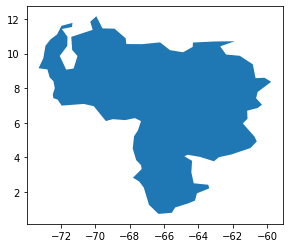

In [6]:
study_area = world[world['name'] == w.value]
study_area.plot();

Based on (Saslow, 2018), we will create a function to set up folder names according to the current date and time.

In [7]:
def make_folder_name(localtime):
    '''
    Function to set up folder names according to our current local date and time
    
    Arguments:
    localtime -- current time as time.struct_time
    
    Returns:
    string -- string for naming folders (month_day_hour_minutes_pm or _am)
    """
    '''
    if localtime.tm_hour > 12:
        string = str(localtime.tm_mon)+'_'+str(localtime.tm_mday)+'_'+\
        str(localtime.tm_hour-12)+'_'+str(localtime.tm_min)+'_pm'
    else:
        string =str(localtime.tm_mon)+'_'+str(localtime.tm_mday)+'_'+\
        str(localtime.tm_hour)+'_'+str(localtime.tm_min)+'_am'
    return string

Through the following lines of code, we will create a list containing names of the datasets an their respective links.

In [8]:
names = ['24hrVIIRS375m','48hrVIIRS375m','7dVIIRS375m']

# comment out this line if you want to download global VIIRS Active Fire 
# download link of current VIIRS Active Fires for South America
links = ['https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_South_America_24h.zip',\
        'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_South_America_48h.zip',\
        'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_South_America_7d.zip']

# uncomment this line if you want to download global VIIRS Active Fire 
# links = ['https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_Global_24h.zip',\
#         'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_Global_48h.zip',\
#         'https://firms.modaps.eosdis.nasa.gov/data/active_fire/noaa-20-viirs-c2/shapes/zips/J1_VIIRS_C2_Global_7d.zip']

Next, we will create the folders, download and unzip the VIIRS-AF data.

In [9]:
# list to store folder names
folder_names = []
localtime = time.localtime(time.time())

# save the data into the right spot
for i, name_Link in enumerate(zip(names, links)):
    # download the file content in binary format
    r = requests.get(name_Link[1])
    
    # open method to open a file on your system and write the contents
    with open(name_Link[0], "wb") as code:
        code.write(r.content)
        
    # unzip data
    zip_ref = zipfile.ZipFile(name_Link[0], 'r')
    name = make_folder_name(localtime)+'_'+name_Link[0]
    folder_names.append(name)
    zip_ref.extractall(name)
    zip_ref.close()
    # remove zipped file after unzipping
    os.remove(name_Link[0])

The following lines will allow us to get the path of the [shapefile](https://en.wikipedia.org/wiki/Shapefile) in each folder.

In [10]:
# VIIRS for the last 24 hours
dir_name_24h = folder_names[0]
filename_24h = [f for f in listdir(dir_name_24h) if isfile(join(dir_name_24h, f))][3]
path_24h = os.path.join(dir_name_24h, filename_24h)

# VIIRS for the last 48 hours
dir_name_48h = folder_names[1]
filename_48h = [f for f in listdir(dir_name_48h) if isfile(join(dir_name_48h, f))][3]
path_48h = os.path.join(dir_name_48h, filename_48h)

# VIIRS for the last 7 days
dir_name_7d = folder_names[2]
filename_7d = [f for f in listdir(dir_name_7d) if isfile(join(dir_name_7d, f))][3]
path_7d = os.path.join(dir_name_7d, filename_7d)

## 2. Processing Data
Through the following function, we will clip each shapefile to our study area (e.g. country boundaries).

In [11]:
def clip_data(path):
    '''Function to clip point shapefile to a polygon
    
    Arguments:
    path --- path containg shapefile
    
    Returns:
    ptclip -- clipped GeoDataFrame
    
    '''
    ptall = gpd.read_file(path)
    
    ptclip = gpd.clip(ptall, study_area)
    
    return ptclip

Let's clip the data and get rid of points with low confidence. We also plot VIIRS-AF points for 24 hours in order to check our results.

In [12]:
# clip data
pt24hclip = clip_data(path_24h)
pt48hclip = clip_data(path_48h)
pt7dclip = clip_data(path_7d)

In [13]:
# get rid of hotspots with low confidence
pt24h = pt24hclip[pt24hclip['CONFIDENCE']!= 'low']
pt48h = pt48hclip[pt48hclip['CONFIDENCE']!= 'low']
pt7d = pt7dclip[pt7dclip['CONFIDENCE']!= 'low']

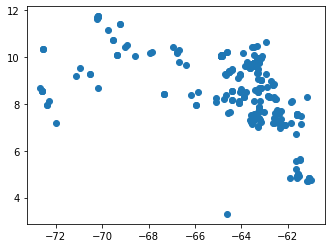

In [14]:
# plot VIIRS-AF points for 24 hours
pt24h.plot();

Through the following function, we will get a list containing latitude and longitude data from each VIIRS-AF points.

In [15]:
def get_locations(pts):
    
    '''Funtion to get a list containing latitude and longitude data from point GeoDataFrame.
    
    Arguments:
    pts --- point GeoDataFrame
    
    Returns:
    locs -- list containing latitude and longitude
    '''
    lats = pts['LATITUDE'].tolist()
    
    lons = pts['LONGITUDE'].tolist()
    
    locs = list(zip(lats, lons))
    
    return locs

Apply the `get_locations()` function to get a list of coordinates that will be used to create Folium [Marker Clusters](https://python-visualization.github.io/folium/plugins.html#folium.plugins.MarkerCluster) and [Heatmaps](https://python-visualization.github.io/folium/plugins.html#folium.plugins.HeatMap).

In [16]:
locations24h = get_locations(pt24h)

locations48h = get_locations(pt48h)

locations7d = get_locations(pt7d)

## 3. Visualize  VIIRS-AFs
The following function allows us to customize the Folium [Popup](https://html-online.com/articles/simple-popup-box/). Through this function,  we will select the most important attributes of each VIIRS-AF point and get a list with styled HTML that will be used to set up the popup window of Folium Markers.

In [17]:
def get_popup(df):
    '''
    Function to configure Folium Popup from point GeoDataFrame
    
    Arguments:
    df --- GeoDataFrame
    
    Returns:
    popup -- list with styled HTML 
    '''
    # select attributes
    bt4 = df['BRIGHT_TI4'].tolist()
    acd = df['ACQ_DATE'].tolist()
    act = df['ACQ_TIME'].tolist()
    con = df['CONFIDENCE'].tolist()
    bt5 = df['BRIGHT_TI5'].tolist()
    frp = df['FRP'].tolist()
    dynt = df['DAYNIGHT']
    
    # convert attributes into list
    poplist = list(zip(bt4, acd, act, con, bt5, frp, dynt))
    
    # use HTML to customize the popup
    popup = ['<div style="width: 250px;">\
                <strong>Brightness temperature I-4 (Kelvin): </strong>{}\
                <br>\
                <strong>Acquisition Date: </strong>{}\
                <br>\
                <strong>Acquisition Time: </strong>{}\
                <br>\
                <strong>Confidence: </strong>{}\
                <br>\
                <strong>Brightness temperature I-5 (Kelvin): </strong>{}\
                <br>\
                <strong>Fire Radiative Power (megawatts): </strong>{}\
                <br>\
                <strong>Day(D) or Night(N): </strong>{}\
            </div>'.format(b4, ad, at, co, b5, fr, dn) for (b4, ad, at, co, b5, fr, dn) in poplist]
    return popup

Next, we will calculate the `location` parameter of the class [`folium.folium.Map()`](http://python-visualization.github.io/folium/modules.html#module-folium.folium).

In [18]:
centx= study_area['geometry'].centroid.x.tolist()
centy= study_area['geometry'].centroid.y.tolist()
location = [*centy, *centx]

To calculate the `zoom_start` parameter (e.g. initial zoom level for the map) of the class [`folium.folium.Map()`](http://python-visualization.github.io/folium/modules.html#module-folium.folium), first we will calculate the bounding box of the study area (code below), then we pass the bounding box coordinates as an argument to the function `get_zoom_start()` included in our custom module `cal_zoom.py`.

In [19]:
bboxsa = study_area.geometry.bounds.values.tolist()
bbox = [item for sublist in bboxsa for item in sublist]

Finally, we will set up our map with Folium library. To do that we will first create a `folium.Map` object passing  the latitude and longitude of map, and  the initial zoom level for the map using our function`get_zoom_start()`. Next, we will add the following objects to our `folium.Map`:
- [CartoDB positron](https://carto.com/blog/getting-to-know-positron-and-dark-matter/) as a tile layer to append on the `folium.Map`object.
- The study area polygon as a GeoJSON object.
- VIIRS-AF heatmaps and marker clusters for the last 24, 48 hours and 7 days.
- Folium [layer control](https://python-visualization.github.io/folium/modules.html#folium.map.LayerControl).
- Map title.
- Map legend using our custom module `map_html.py`.

In [21]:
# create folium.Map objet 
map = folium.Map(location, zoom_start=get_zoom_start(bbox), tiles=False,control_scale=True, \
                 prefer_canvas=True)


# adding CartoDB positron as a tile layer
folium.TileLayer('CartoDB dark_matter', overlay=True).add_to(map)


# add the study area boundaries as GeoJSON
def style_function(feature):
    '''function to style GeoJSON '''
    return {
        "fill": False,
        "color": "white",
        "weight": 2
    }
folium.GeoJson(study_area, name=w.value, style_function=style_function).add_to(map)


# add heatmaps
# heatmap 24 hours
pt24h_hm = plugins.HeatMap(locations24h,
                         name='Heatmap 24hr VIIRS',
                         overlay=True,
                         control=True,
                         show=False)
pt24h_hm.add_to(map)

# heatmap 48 hours
pt48h_hm = plugins.HeatMap(locations48h,
                         name='Heatmap 48hr VIIRS',
                         overlay=True,
                         control=True,
                         show=False)
pt48h_hm.add_to(map)

# heatmap 7 days
pt7d_hm = plugins.HeatMap(locations7d,
                         name='Heatmap 7d VIIRS',
                         overlay=True,
                         control=True,
                         show=False)
pt7d_hm.add_to(map)

# add Marker Cluster
pointIcon24h = "./icons/fire24.png" # custom icon VIIRS-AF 24 hours
pointIcon48h = "./icons/fire48.png" # custom icon VIIRS-AF 48 hours
pointIcon7d = "./icons/fire7d.png"  # custom icon VIIRS-AF 7 days



cluster24h = MarkerCluster(name='24hr VIIRS 375m', overlay=False).add_to(map)
cluster48h = MarkerCluster(name='48hr VIIRS 375m', overlay=False).add_to(map)
cluster7d = MarkerCluster(name='7d VIIRS 375m', overlay=False).add_to(map)

for loc24h, pop24h in zip(locations24h, get_popup(pt24h)):
    folium.Marker(loc24h,
                  icon=folium.features.CustomIcon(pointIcon24h, icon_size=(40, 40)),
                  popup=pop24h,
                 ).add_to(cluster24h)
for loc48h, pop48h in zip(locations48h, get_popup(pt48h)):
    folium.Marker(loc48h,
                  icon=folium.features.CustomIcon(pointIcon48h, icon_size=(40, 40)),
                  popup=pop48h               
              ).add_to(cluster48h)
for loc7d, pop7d in zip(locations7d, get_popup(pt7d)):
    folium.Marker(loc7d,
                  icon=folium.features.CustomIcon(pointIcon7d, icon_size=(40, 40)),
                  popup=pop7d
              ).add_to(cluster7d)

# add  layer control
folium.LayerControl(collapsed=False).add_to(map)

# add map title
text = 'VIIRS Active Fires in '
date = str(localtime.tm_year)+'/'+str(localtime.tm_mon)+'/'+str(localtime.tm_mday)
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(text + w.value + ' ' + 'on' + ' ' + date)   
map.get_root().html.add_child(folium.Element(title_html));

# add map legend
map_html.legend(map)

Let's visualize the map.

In [22]:
map

## 4. Conclusions

- VIIRS-AF is a remarkable geospatial product that provides us hints about thermal anomalies and possible wildfire events. 
- Geopandas is a powerful Python library that allow us to read and process any geospatial data format. In this case, we easily read and processed VIIRS-AF shapefile point data. 
- Folium Marker Cluster in conjunction with Heatmaps points  out where AFs clusters are occurring. In our case we observed that on 2021/9/12, most of AFs are present in the eastern region in Venezuela, so we should further investigate why it is occurring.

## 5. References

Joint Polar Satellite System (n.d.). VIIRS Active Fire Quick Guide. Retrieved September 11, 2021, from https://rammb2.cira.colostate.edu/wp-content/uploads/2020/09/VIIRS_Active_Fire_Quick_Guide_v6.pdf. 

National Aeronautics and Space Administration (2021). VIIRS I-Band 375 m Active Fire Data | Earthdata. VIIRS I-Band 375 m Active Fire Data. Retrieved September 11, 2021, from https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/viirs-i-band-active-fire-data.

Saslow, E. (2018). Geo libraries in Python (Plotting current fires). Retrieved September 11, 2021, from https://blog.goodaudience.com/geo-libraries-in-python-plotting-current-fires-bffef9fe3fb7
